<a href="https://colab.research.google.com/github/Gladwin-George/Image-Processing-with-Deep-Neural-Networks/blob/main/Task_2_catvsdog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Task 2: Image Processing with Deep Neural Networks (DNNs)**


---

---



## **Dataset: Oxford Pets**


This notebook explores the use of a pretrained Deep Neural Network (DINOv2) for image processing and feature extraction. Images are transformed into compact, information-rich feature vectors (latent representations), which are then analysed using dimensionality reduction, clustering, and classification techniques.

The workflow includes:
- loading and preprocessing the Cats vs Dogs image dataset,
- extracting deep feature embeddings using the pretrained DINOv2 model,
- visualising the latent feature space using PCA and t-SNE,
- evaluating unsupervised structure with K-Means clustering,
- assessing feature quality using a logistic regression classifier.

This approach demonstrates how pretrained DNNs can be effectively used for representation learning without fine-tuning the network.

# Mounting Google Drive

Mounts your Google Drive inside Colab so you can read datasets and save outputs (For colab).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Imported necessary libraries**
Imports all libraries required for image loading, deep feature extraction, visualisation, clustering, and classification.


In [ ]:
import os
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from transformers import AutoImageProcessor, AutoModel

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from sklearn.preprocessing import StandardScaler, normalize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import (
    davies_bouldin_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)


**Device setup for CUDA enabled GPU**

Selects GPU (CUDA) if available, otherwise uses CPU, to ensure the code runs efficiently on the available hardware.



In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


# Dataset Loading and Verification
Loads the Cats vs Dogs dataset using `ImageFolder`, automatically assigns labels from folder names, and counts image files to verify that all images are correctly detected.




In [ ]:
# Cats vs Dogs
DATASET_ROOT = "/content/drive/MyDrive/task2/data/PetImages"


In [ ]:
dataset = datasets.ImageFolder(DATASET_ROOT)
print("Classes:", dataset.classes)
print("Total images:", len(dataset))


Classes: ['Cat', 'Dog']
Total images: 24958


In [ ]:
def count_images(root_dir):
    total = 0
    for class_name in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        total += len(os.listdir(class_path))
    return total

print("Total image files found:", count_images(DATASET_ROOT))


Total image files found: 24958


# Image Preprocessing
Resizes images to the model input size, converts them to tensors, and normalises them using ImageNet statistics before loading the dataset.

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])


In [ ]:
dataset = datasets.ImageFolder(DATASET_ROOT, transform=transform)

print("Number of images:", len(dataset))
print("Classes:", dataset.classes)


Number of images: 24958
Classes: ['Cat', 'Dog']


# DataLoader and Model Initialisation
Creates a DataLoader for batch-wise image processing and loads the pretrained DINOv2-small model in evaluation mode with all parameters frozen for feature extraction.


In [ ]:
loader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


In [ ]:
processor = AutoImageProcessor.from_pretrained("facebook/dinov2-small")
model = AutoModel.from_pretrained("facebook/dinov2-small")
model.to(device)
model.eval()


Dinov2Model(
  (embeddings): Dinov2Embeddings(
    (patch_embeddings): Dinov2PatchEmbeddings(
      (projection): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): Dinov2Encoder(
    (layer): ModuleList(
      (0-11): 12 x Dinov2Layer(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attention): Dinov2Attention(
          (attention): Dinov2SelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
          )
          (output): Dinov2SelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (layer_scale1): Dinov2LayerScale()
        (drop_path): Identity()
        (norm2): LayerNorm((384,), eps=1e-06,

In [ ]:
for param in model.parameters():
    param.requires_grad = False


# Feature Extraction and Saving

Extracts CLS token embeddings from the DINOv2 model as feature vectors for each image, stores the corresponding labels, saves them to disk, and reloads them for later analysis without recomputing features.

In [ ]:
features = []
labels = []

with torch.no_grad():
    for batch_idx, (imgs, lbls) in enumerate(loader):
        imgs = imgs.to(device, non_blocking=True)

        outputs = model(pixel_values=imgs)
        cls_embeddings = outputs.last_hidden_state[:, 0, :]  # CLS token

        features.append(cls_embeddings.cpu().numpy())
        labels.append(lbls.numpy())

        if batch_idx % 20 == 0:
            print(f"Processed {batch_idx * loader.batch_size} images")

# Convert to arrays
X = np.vstack(features)
y = np.hstack(labels)

print("Final feature shape:", X.shape)
print("Final label shape:", y.shape)


Processed 0 images
Processed 640 images
Processed 1280 images
Processed 1920 images
Processed 2560 images
Processed 3200 images
Processed 3840 images
Processed 4480 images
Processed 5120 images
Processed 5760 images
Processed 6400 images
Processed 7040 images
Processed 7680 images
Processed 8320 images
Processed 8960 images
Processed 9600 images
Processed 10240 images
Processed 10880 images
Processed 11520 images
Processed 12160 images
Processed 12800 images
Processed 13440 images
Processed 14080 images
Processed 14720 images
Processed 15360 images
Processed 16000 images
Processed 16640 images
Processed 17280 images
Processed 17920 images
Processed 18560 images
Processed 19200 images
Processed 19840 images
Processed 20480 images
Processed 21120 images
Processed 21760 images
Processed 22400 images
Processed 23040 images
Processed 23680 images


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Processed 24320 images
Final feature shape: (24958, 384)
Final label shape: (24958,)


In [ ]:
SAVE_DIR = "/content/drive/MyDrive/task2/features/catvsdogs"

os.makedirs(SAVE_DIR, exist_ok=True)

FEATURE_PATH = os.path.join(SAVE_DIR, "features.npy")
LABEL_PATH   = os.path.join(SAVE_DIR, "labels.npy")

np.save(FEATURE_PATH, X)
np.save(LABEL_PATH, y)

print("✅ Features and labels saved successfully!")
print("📁 Features:", FEATURE_PATH)
print("📁 Labels:", LABEL_PATH)

✅ Features and labels saved successfully!
📁 Features: /content/drive/MyDrive/task2/features/catvsdogs/features.npy
📁 Labels: /content/drive/MyDrive/task2/features/catvsdogs/labels.npy


In [ ]:
FEATURE_PATH = "/content/drive/MyDrive/task2/features/catvsdogs/features.npy"
LABEL_PATH   = "/content/drive/MyDrive/task2/features/catvsdogs/labels.npy"

X = np.load(FEATURE_PATH)
y = np.load(LABEL_PATH)

print("Features shape:", X.shape)
print("Labels shape:", y.shape)


Features shape: (24958, 384)
Labels shape: (24958,)


# PCA and t-SNE Visualisation

Standardises the extracted features to ensure equal scaling, applies PCA to reduce dimensionality and capture the main variance for clearer visualisation, and then uses t-SNE to project the high-dimensional features into 2D while preserving local neighbourhood structure, allowing visual inspection of class separation between cats and dogs.

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)


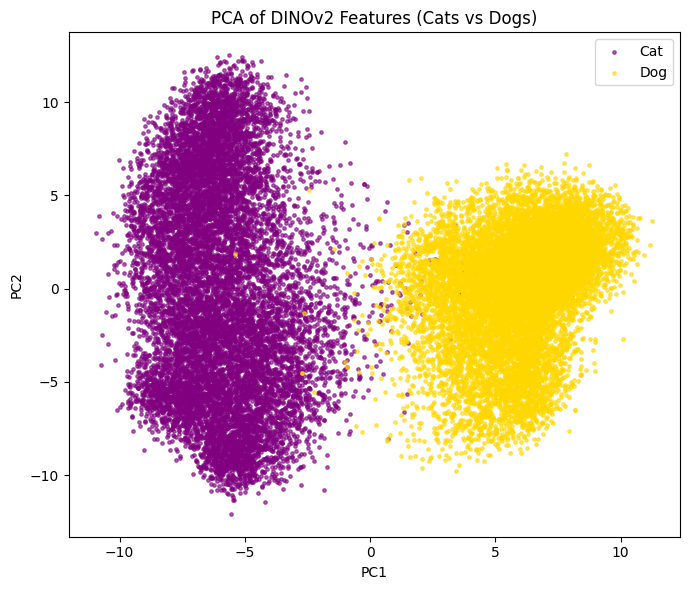

In [ ]:
plt.figure(figsize=(7, 6))

# Cat = 0
plt.scatter(
    X_pca[y == 0, 0],
    X_pca[y == 0, 1],
    color="purple",
    label="Cat",
    s=6,
    alpha=0.6
)

# Dog = 1
plt.scatter(
    X_pca[y == 1, 0],
    X_pca[y == 1, 1],
    color="gold",
    label="Dog",
    s=6,
    alpha=0.6
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of DINOv2 Features (Cats vs Dogs)")
plt.legend()
plt.tight_layout()
plt.show()


**t-SNE Visualisation with PCA Preprocessing**


Standardises the feature vectors and applies PCA to reduce dimensionality and remove noise, then uses t-SNE to project the features into two dimensions while preserving local similarities, enabling visual analysis of how well the DINOv2 embeddings separate cats and dogs.

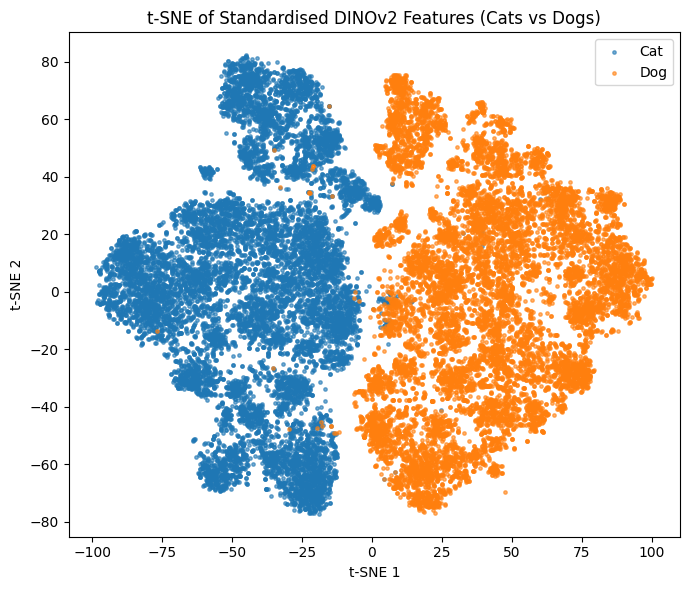

In [ ]:
X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=50, random_state=42)
X_50 = pca.fit_transform(X_scaled)

tsne = TSNE(
    n_components=2,
    perplexity=30,
    init="pca",
    learning_rate="auto",
    max_iter=1000,
    random_state=42
)

X_tsne = tsne.fit_transform(X_50)

# plotting
plt.figure(figsize=(7, 6))

plt.scatter(
    X_tsne[y == 0, 0],
    X_tsne[y == 0, 1],
    s=6,
    alpha=0.6,
    label="Cat"
)

plt.scatter(
    X_tsne[y == 1, 0],
    X_tsne[y == 1, 1],
    s=6,
    alpha=0.6,
    label="Dog"
)

plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE of Standardised DINOv2 Features (Cats vs Dogs)")
plt.legend()
plt.tight_layout()
plt.show()


# **Clustering with K-Means and Evaluation**

Applies L2 normalisation to the DINOv2 feature vectors, reduces dimensionality using PCA, and performs K-Means clustering to group images into two clusters, then evaluates clustering quality using the Davies–Bouldin Index and visualises the clusters in a 2D PCA space.

In [ ]:
X_l2 = normalize(X, norm="l2")

pca = PCA(n_components=50, random_state=42)
X_l2_pca = pca.fit_transform(X_l2)

kmeans = KMeans(
    n_clusters=2,
    random_state=42,
    n_init=50
)
clusters = kmeans.fit_predict(X_l2_pca)

db = davies_bouldin_score(X_l2_pca, clusters)
print("Davies–Bouldin Index (L2 + PCA + KMeans):", db)

Davies–Bouldin Index (L2 + PCA + KMeans): 2.43312149502091


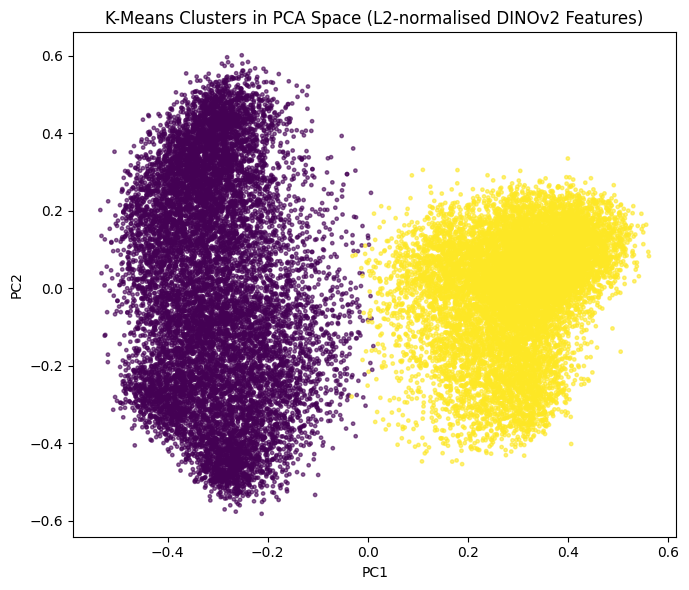

In [ ]:
pca_2d = PCA(n_components=2, random_state=42)
X_vis = pca_2d.fit_transform(X_l2)

plt.figure(figsize=(7, 6))
plt.scatter(
    X_vis[:, 0],
    X_vis[:, 1],
    c=clusters,
    cmap="viridis",
    s=6,
    alpha=0.6
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K-Means Clusters in PCA Space (L2-normalised DINOv2 Features)")
plt.tight_layout()
plt.show()


# **Classification Using Logistic Regression**

Splits the extracted features into training and testing sets, trains a logistic regression classifier as a linear probe on the DINOv2 embeddings, and evaluates performance using standard classification metrics and a confusion matrix to assess how well the features separate cats and dogs.

In [ ]:
# 1. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_l2_pca,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 2. Train classifier (linear layer equivalent)
start_time = time.time()

clf = LogisticRegression(
    max_iter=1000,
    random_state=42
)
clf.fit(X_train, y_train)

training_time = time.time() - start_time

# 3. Predictions
y_pred = clf.predict(X_test)

# 4. Metrics
print("Training time (s):", training_time)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Training time (s): 0.38767361640930176
Accuracy: 0.9985977564102564
Precision: 0.9987966305655837
Recall: 0.9983961507618284
F1 score: 0.9985963505113294

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2498
           1       1.00      1.00      1.00      2494

    accuracy                           1.00      4992
   macro avg       1.00      1.00      1.00      4992
weighted avg       1.00      1.00      1.00      4992



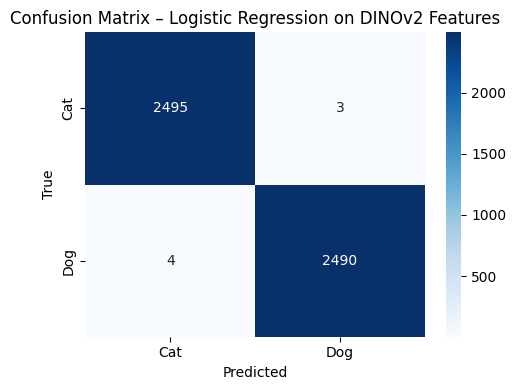

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Cat", "Dog"],
    yticklabels=["Cat", "Dog"]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – Logistic Regression on DINOv2 Features")
plt.tight_layout()
plt.show()


# **Conclusion**

The logistic regression classifier trained on DINOv2 features demonstrates exceptionally strong performance, achieving an accuracy of 99.86% with precision, recall, and F1-scores all close to 1.0. The confusion matrix shows only 7 misclassifications out of 4,992 samples, indicating that both classes (cats and dogs) are almost perfectly separated